<a href="https://colab.research.google.com/github/cole-beach/MLB-Predictions/blob/main/MLB_OBP_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
path = '/content/drive/MyDrive/MLB Predictions/FanGraphs Leaderboard.csv'
df = pd.read_csv(path)
df.head()

,Name,Team,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,...,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,playerid
0,Mike Trout,LAA,3465,17.20%,21.00%,0.82,0.304,0.434,0.606,1.039,...,5.6,0.339,11.8,11.5,8.4,735,321.3,0.429,176,10155
1,Juan Soto,WSN,2003,18.60%,17.60%,1.06,0.301,0.432,0.550,0.981,...,4.4,0.330,-1.7,-0.2,-0.4,401,156.6,0.410,156,20123
2,Bryce Harper,PHI,3993,17.00%,21.80%,0.78,0.282,0.407,0.548,0.954,...,4.1,0.320,-5.6,5.3,2.1,743,265.3,0.398,148,11579
3,Aaron Judge,NYY,2465,14.60%,29.70%,0.49,0.276,0.386,0.554,0.940,...,3.5,0.346,3.6,-0.1,-2.1,456,156.9,0.394,151,15640
4,Joey Votto,CIN,4066,16.80%,18.00%,0.93,0.293,0.416,0.508,0.923,...,3.2,0.328,-23.2,-0.8,1.3,739,253.4,0.392,143,4314


In [ ]:
df.describe()

,PA,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,playerid
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.00000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,2473.935323,0.435871,0.261756,0.334169,0.446667,0.780761,0.184851,4.135323,0.304328,0.737811,0.38806,0.272637,340.009950,42.028856,0.333343,108.034826,12091.985075
std,937.033282,0.162630,0.022490,0.028128,0.053002,0.073990,0.046482,1.512877,0.025036,8.330904,4.43515,4.243995,162.765905,70.828078,0.028349,19.201140,4430.946178
min,1006.000000,0.130000,0.194000,0.249000,0.318000,0.596000,0.078000,1.100000,0.237000,-25.000000,-11.60000,-7.800000,107.000000,-93.300000,0.255000,57.000000,1177.000000
25%,1606.000000,0.330000,0.245000,0.317000,0.409000,0.731000,0.153000,2.900000,0.288000,-4.100000,-2.00000,-2.000000,206.000000,-4.000000,0.315000,95.000000,9874.000000
50%,2459.000000,0.410000,0.262000,0.333000,0.445000,0.776000,0.185000,4.100000,0.306000,1.100000,0.50000,-0.900000,337.000000,24.700000,0.332000,108.000000,12532.000000
75%,3184.000000,0.520000,0.278000,0.348000,0.489000,0.828000,0.217000,5.200000,0.323000,6.400000,3.10000,1.200000,438.000000,72.000000,0.351000,120.000000,15161.000000
max,4363.000000,1.060000,0.308000,0.434000,0.606000,1.039000,0.301000,9.000000,0.374000,22.100000,12.30000,22.200000,763.000000,321.300000,0.429000,176.000000,20123.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      201 non-null    object 
 1   Team      201 non-null    object 
 2   PA        201 non-null    int64  
 3   BB%       201 non-null    object 
 4   K%        201 non-null    object 
 5   BB/K      201 non-null    float64
 6   AVG       201 non-null    float64
 7   OBP       201 non-null    float64
 8   SLG       201 non-null    float64
 9   OPS       201 non-null    float64
 10  ISO       201 non-null    float64
 11  Spd       201 non-null    float64
 12  BABIP     201 non-null    float64
 13  UBR       201 non-null    float64
 14  wGDP      201 non-null    float64
 15  wSB       201 non-null    float64
 16  wRC       201 non-null    int64  
 17  wRAA      201 non-null    float64
 18  wOBA      201 non-null    float64
 19  wRC+      201 non-null    int64  
 20  playerid  201 non-null    int64 

In [ ]:
df['BB%'] = (df['BB%'].str.strip('%').astype(float))
df['K%'] = (df['K%'].str.strip('%').astype(float))


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      201 non-null    object 
 1   Team      201 non-null    object 
 2   PA        201 non-null    int64  
 3   BB%       201 non-null    float64
 4   K%        201 non-null    float64
 5   BB/K      201 non-null    float64
 6   AVG       201 non-null    float64
 7   OBP       201 non-null    float64
 8   SLG       201 non-null    float64
 9   OPS       201 non-null    float64
 10  ISO       201 non-null    float64
 11  Spd       201 non-null    float64
 12  BABIP     201 non-null    float64
 13  UBR       201 non-null    float64
 14  wGDP      201 non-null    float64
 15  wSB       201 non-null    float64
 16  wRC       201 non-null    int64  
 17  wRAA      201 non-null    float64
 18  wOBA      201 non-null    float64
 19  wRC+      201 non-null    int64  
 20  playerid  201 non-null    int64 

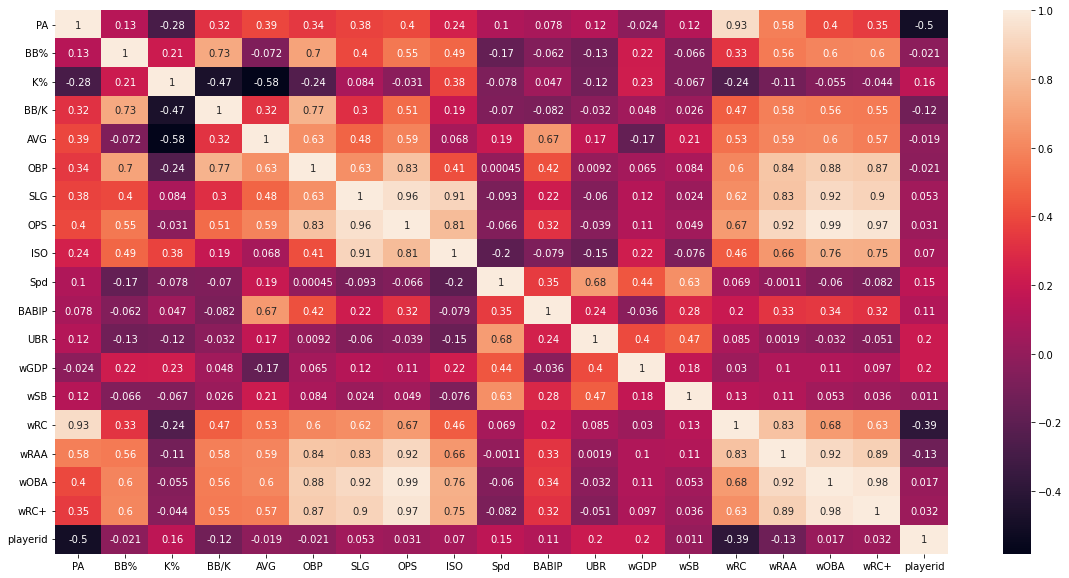

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, ax=ax);

In [ ]:
top_hitters = df.head(20)

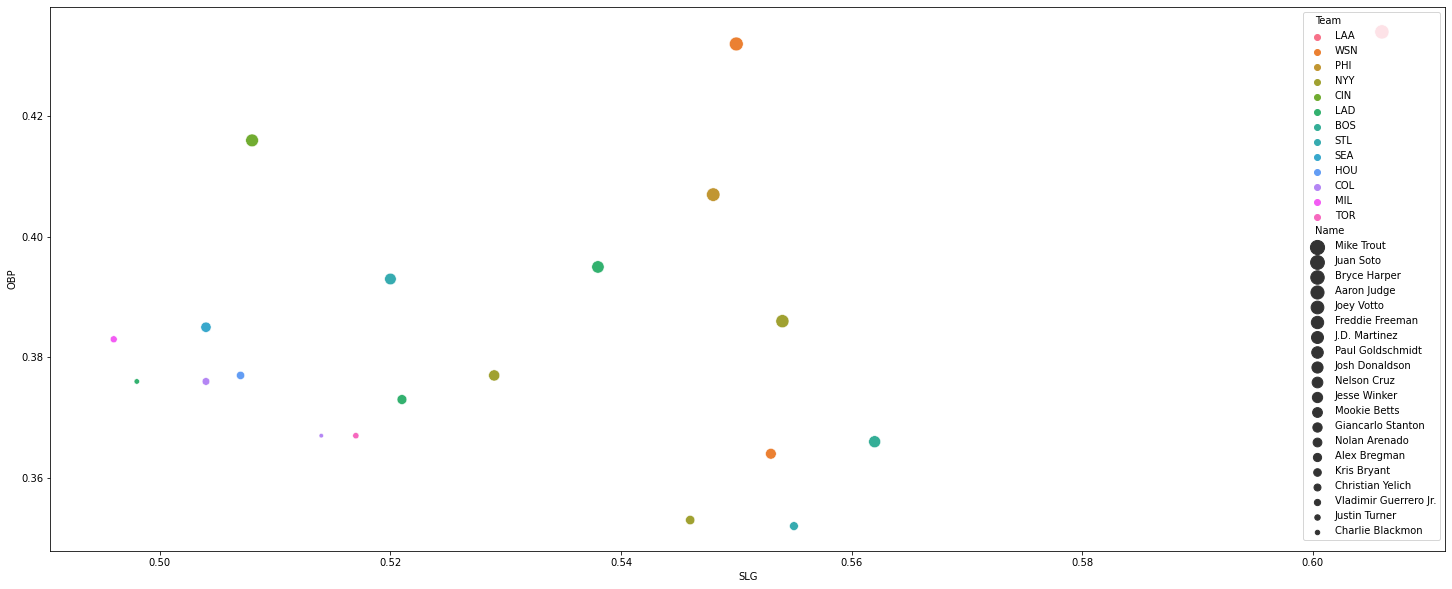

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(25,10))
sns.scatterplot(
    data=top_hitters, x="SLG", y="OBP", hue="Team", size="Name",
    sizes=(20, 200), legend="full"
);

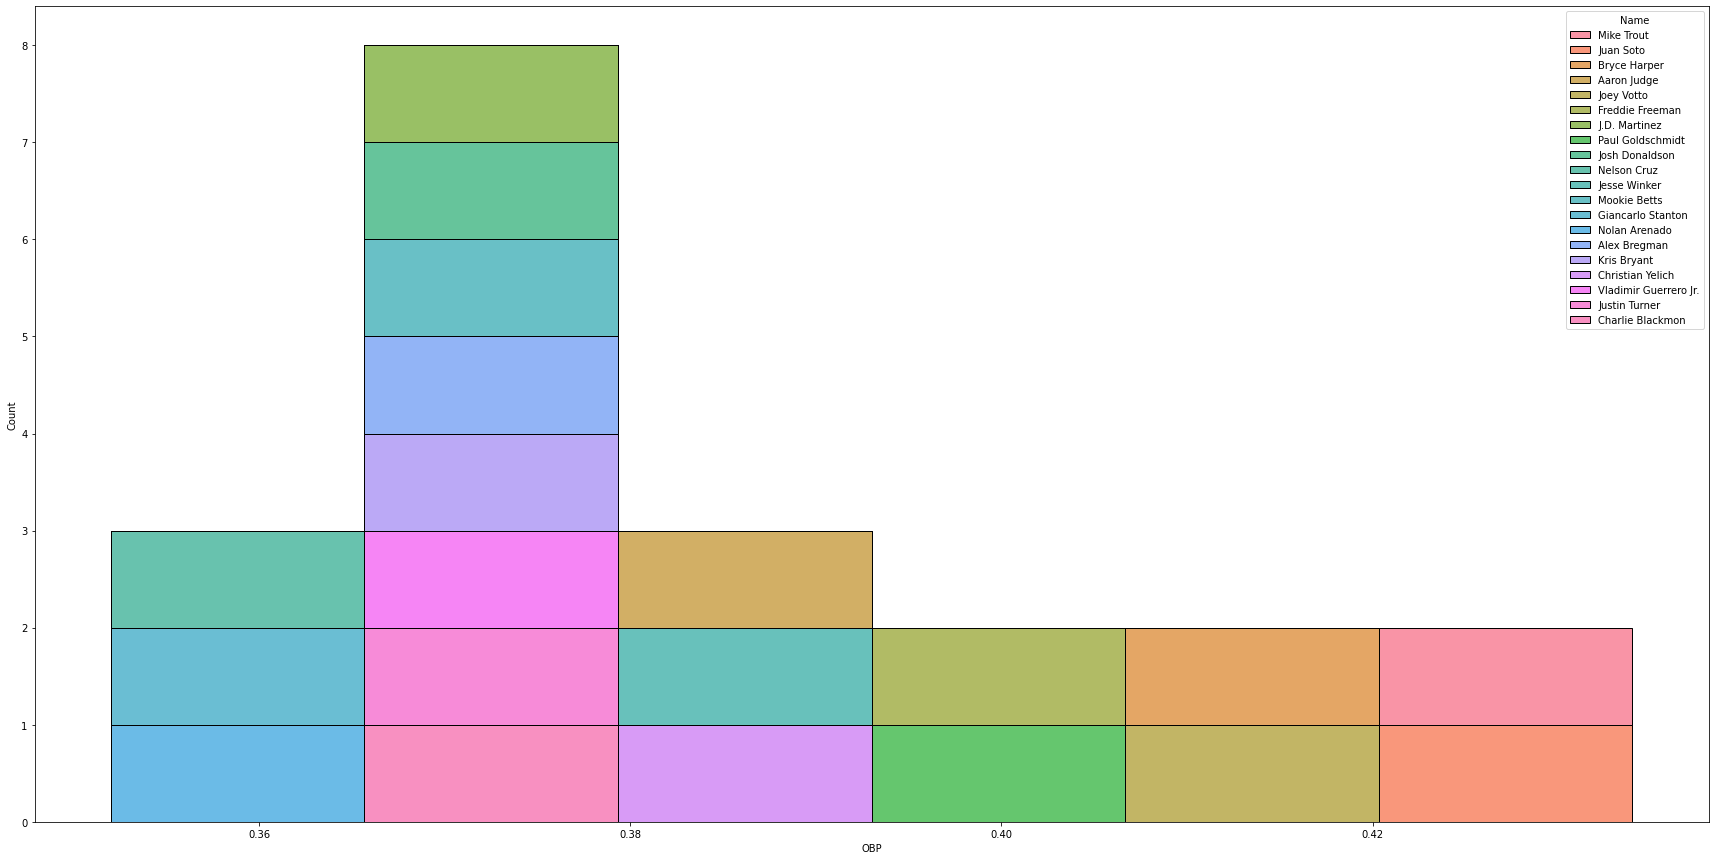

In [ ]:
plt.figure(figsize = (30,15));
sns.histplot(data=top_hitters, x="OBP", hue="Name", multiple="stack");

In [ ]:
X = df.drop(columns = ['Name', 'Team'])
# Encoding our targets using the LabelEncoder for PCA Data Viz
le = LabelEncoder()
y = le.fit_transform(df['Name'])

In [ ]:
# Instantiate Standard Scaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

In [ ]:
# Instantiate, fit & transform data using PCA
pca = PCA(n_components=4)
pcs = pca.fit_transform(scaled_df)

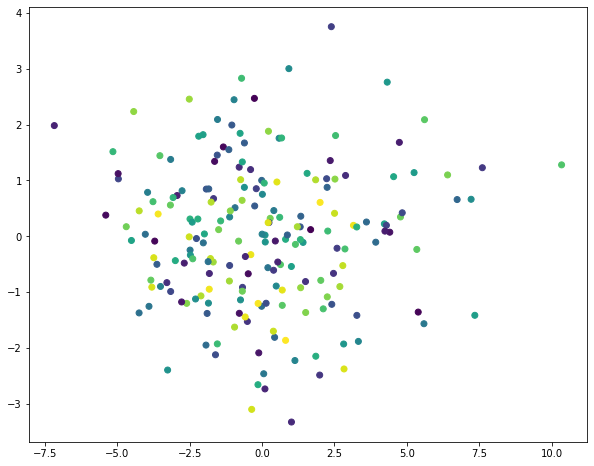

In [ ]:
# Visualize the first 2 PCs
plt.figure(figsize=(10,8))
plt.scatter(pcs[:,0], pcs[:,3], c=y);


In [ ]:
# (a) Cluster the data using most or all features and analyze those clusters to explain how the clusters are different. 
# (no train test split required)
df2 = df.drop(columns=['Team', 'Name'])

scaler = StandardScaler()
scaler_x = pd.DataFrame(scaler.fit_transform(df2))

In [ ]:
def plot_k_values(data, ks):
  sils = []
  inertias = []
  for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(data)
    sils.append(silhouette_score(data, km.labels_))
    inertias.append(km.inertia_)
      
  # plot inertia and silhouette score
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.set_xlabel('number of clusters')
  ax1.set_ylabel('Inertia', color = 'blue')
  ax1.plot(ks, inertias, color = 'blue',label='inertia',marker ='o')

  
  ax2 = ax1.twinx() 
  
  ax2.set_ylabel('Silhouette Score', color = 'red')
  ax2.plot(ks, sils, color = 'red',label='silhouette score',marker='+')
  ax1.legend(loc=0)  
  ax2.legend(loc='upper left')
  plt.grid(True)
  plt.show()

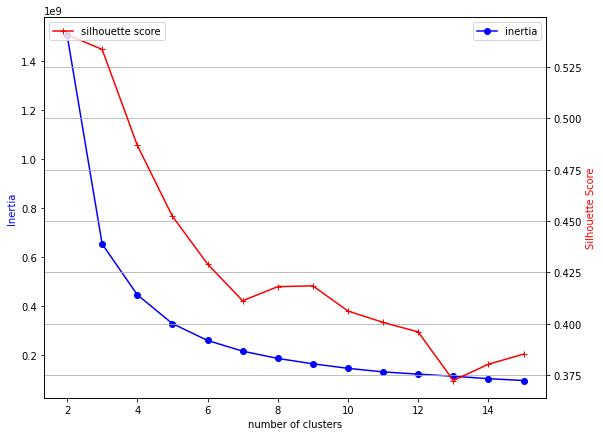

In [ ]:
ks = range(2,16)
plot_k_values(df2, ks)

Try 2, 6

In [ ]:
km = KMeans(n_clusters=12, random_state=42)
df2['cluster'] = km.fit_predict(scaler_x)
df2.head()

,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,playerid,cluster
0,3465,17.2,21.0,0.82,0.304,0.434,0.606,1.039,0.301,5.6,0.339,11.8,11.5,8.4,735,321.3,0.429,176,10155,2
1,2003,18.6,17.6,1.06,0.301,0.432,0.550,0.981,0.249,4.4,0.330,-1.7,-0.2,-0.4,401,156.6,0.410,156,20123,9
2,3993,17.0,21.8,0.78,0.282,0.407,0.548,0.954,0.265,4.1,0.320,-5.6,5.3,2.1,743,265.3,0.398,148,11579,9
3,2465,14.6,29.7,0.49,0.276,0.386,0.554,0.940,0.278,3.5,0.346,3.6,-0.1,-2.1,456,156.9,0.394,151,15640,9
4,4066,16.8,18.0,0.93,0.293,0.416,0.508,0.923,0.215,3.2,0.328,-23.2,-0.8,1.3,739,253.4,0.392,143,4314,9


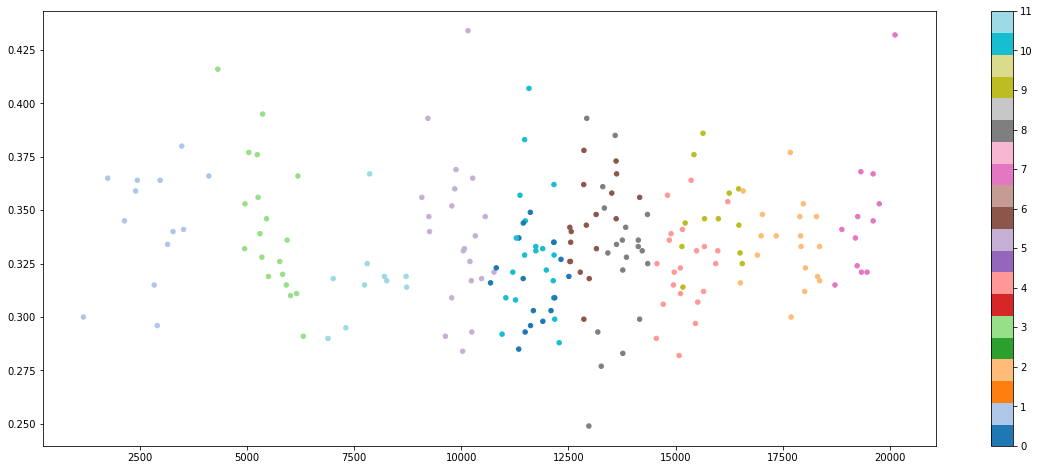

In [ ]:
km = KMeans(n_clusters=12, random_state=42)
km.fit(df2)

# kmeans
plt.figure(figsize=(20,8))
plt.scatter( x=df2["playerid"], y=df2["OBP"], c=km.labels_, 
         cmap = 'tab20', s=20)
ticks = np.sort(np.unique(km.labels_))
plt.colorbar(ticks=ticks);

In [ ]:
X = df2.drop(columns=['OBP'])
y = df2['OBP']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns= X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train

,PA,BB%,K%,BB/K,AVG,SLG,OPS,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,playerid,cluster
0,-0.091522,-0.248378,0.763119,-0.714519,-2.312176,-1.837060,-1.884761,-0.998585,-1.521713,-1.817821,-1.494250,-0.949829,-0.673336,-0.782214,-1.619359,-1.871470,-1.811897,-1.191533,0.836611
1,1.873790,-0.843989,-0.268757,-0.714519,1.075469,1.067204,0.904369,0.710447,-0.983798,0.567184,-0.968442,-2.773870,-0.673336,1.866649,1.355557,0.827056,0.943840,0.793529,-0.032595
2,0.290740,0.115606,-0.568939,0.421536,1.553213,1.049052,1.149709,0.460344,-0.378642,1.242935,0.909445,-0.118620,-0.507080,0.635742,0.965270,1.164372,1.194362,0.330070,-0.322331
3,0.225088,-0.744721,1.232154,-1.192858,-1.226392,0.558957,-0.154467,1.231493,-0.176924,-1.460070,-0.430114,1.705420,-0.483330,-0.027982,-0.399371,-0.353549,-0.509185,-0.273873,0.546875
4,-1.223482,-1.307242,1.438529,-1.611405,-1.573843,-1.582937,-1.807285,-1.061111,1.504063,0.050433,0.621502,0.735677,0.157943,-1.337329,-1.139006,-1.837738,-1.761793,0.659370,-1.191536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,-0.632618,-0.843989,-1.319394,0.062782,0.423998,0.068863,-0.064079,-0.102386,-0.580361,-0.704818,-0.617903,-0.949829,-0.673336,-0.583097,-0.328409,-0.151160,-0.058246,0.852478,-0.612066
156,0.405101,1.141381,-1.394440,2.693648,0.858312,1.103507,1.330486,0.856340,0.226513,-0.506068,-0.380037,0.089182,0.157943,0.852961,1.266855,1.400493,1.595196,1.245696,1.126346
157,0.120258,0.148696,1.138347,-0.594934,-0.053746,0.050711,0.052135,0.085191,1.436824,1.441685,1.159830,1.312905,0.585458,0.080627,-0.028188,0.084961,0.142171,0.360109,0.546875
158,-0.303301,-0.612363,-0.681507,-0.236180,-0.444628,-1.056539,-1.122915,-0.998585,1.302345,-0.625318,0.521348,0.666410,-0.103316,-0.661537,-1.048939,-1.196838,-1.060333,0.575803,0.257140


In [ ]:
# Without clusters
model = LinearRegression()
model.fit(X_train, y_train)

print(f'Training r2:', model.score(X_train, y_train))
print(f'Testing r2:', model.score(X_test, y_test))

Training r2: 0.9997733121629045
Testing r2: 0.9995589025339507


In [ ]:
def plot_k_values(data, ks):
  """plot the silhouette score and inertia 
  of a KMeans model for various k values"""

  sils = []
  inertias = []

  for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(data)
    sils.append(silhouette_score(data, km.labels_))
    inertias.append(km.inertia_)
      
  # plot inertia and silhouette score
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.set_xlabel('number of clusters')
  ax1.set_ylabel('Inertia', color = 'blue')
  ax1.plot(ks, inertias, color = 'blue',label='inertia',marker ='o')

  
  ax2 = ax1.twinx() 
  
  ax2.set_ylabel('Silhouette Score', color = 'red')
  ax2.plot(ks, sils, color = 'red',label='silhouette score',marker='+')
  ax1.legend(loc=0)  
  ax2.legend(loc='upper left')
  plt.grid()
  plt.show()

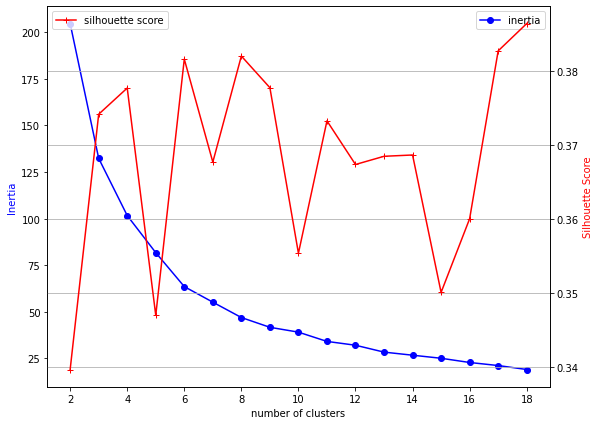

In [ ]:
df2_hitting = X_train[['playerid', 'OPS']]

ks = range(2,19)
plot_k_values(df2_hitting, ks);

2, 7, 8, 14, 16 

In [ ]:
km = KMeans(n_clusters = 2, random_state=42)

km.fit(X_train)
X_train['cluster'] = km.predict(X_train)
X_test['cluster'] = km.predict(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

print(f'Linear Regression Training r2:', model.score(X_train, y_train))
print(f'Linear Regression Testing r2:', model.score(X_test, y_test))
print('\n')
print(f'Training R2:', model.score(X_train, y_train))
print(f'Testing R2:', model.score(X_test, y_test))

Linear Regression Training r2: 0.9997725707602914
Linear Regression Testing r2: 0.999557304457557


Training R2: 0.9997725707602914
Testing R2: 0.999557304457557
